In [ ]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

N = 60 # Number of days used to predict
M = 1 # How many days want to predict
features = ['Open', 'High', 'Low', 'Close', 'Volume']

train_file = '/content/drive/MyDrive/Google_Stock_Price_Train.csv'
test_file = '/content/drive/MyDrive/Google_Stock_Price_Test.csv'


X_train shape: (946, 60, 5) y_train shape: (946, 5)
X_val shape: (192, 60, 5) y_val shape: (192, 5)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 60, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,269 (200.27 KB)

 Trainable params: 51,269 (200.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0679 - val_loss: 0.0032
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0079 - val_loss: 0.0032
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0067 - val_loss: 0.0024
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0062 - val_loss: 0.0018
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0055 - val_loss: 0.0034
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0049 - val_loss: 9.4139e-04
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0053 - val_loss: 0.0013
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0049 - val_loss: 0.0011
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - val_loss: 0.0015
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0052 - val_loss: 0.0011
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss:

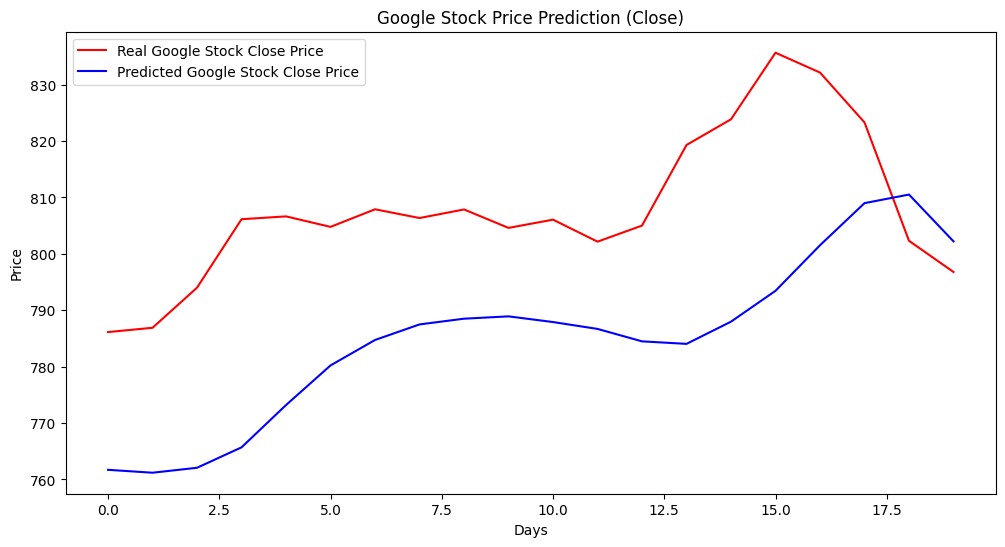

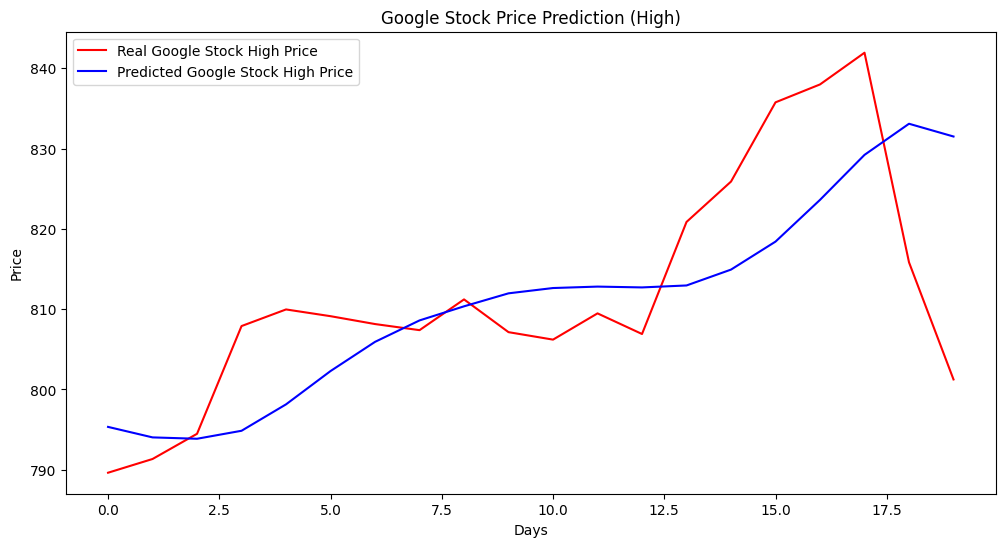

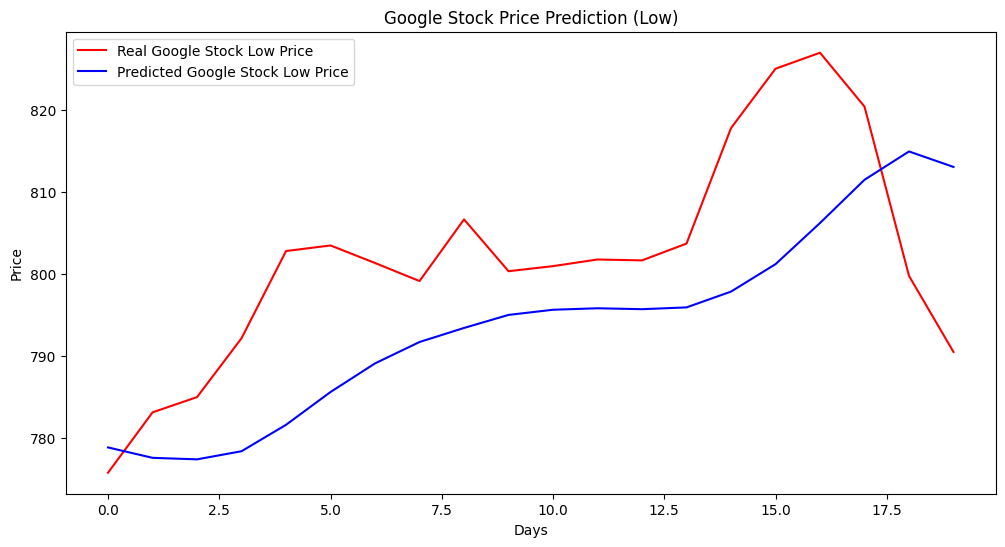

Close Price Metrics:
MSE: 684.5867, RMSE: 26.1646, MAE: 24.1843, MAPE: 2.99%
High Price Metrics:
MSE: 128.9924, RMSE: 11.3575, MAE: 8.8136, MAPE: 1.08%
Low Price Metrics:
MSE: 191.9762, RMSE: 13.8555, MAE: 12.1738, MAPE: 1.51%


In [ ]:
train_df = pd.read_csv(train_file)
if 'Date' in train_df.columns:
    train_df['Date'] = pd.to_datetime(train_df['Date'])
    train_df = train_df.sort_values('Date')

# Remove commas and convert to float
for col in features:
    train_df[col] = train_df[col].astype(str).str.replace(',', '')
    train_df[col] = train_df[col].astype(float)

training_data = train_df[features].values

# Normalize the training data
scaler = MinMaxScaler(feature_range=(0,1))
training_data_scaled = scaler.fit_transform(training_data)

# Split into training and validation sets
train_size = int(len(training_data_scaled)*0.8)
train_data = training_data_scaled[:train_size]
val_data = training_data_scaled[train_size:]

def create_sequences(dataset, N, M):
    X, y = [], []
    for i in range(N, len(dataset)-M+1):
        X.append(dataset[i-N:i])
        y.append(dataset[i:i+M])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, N, M)
X_val, y_val = create_sequences(val_data, N, M)

# Reshape y arrays from (samples, M, features) to (samples, features)
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)


# Model Construction

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(N, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(M * len(features)))  # Output M*features, here M=1

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
model.summary()

# Model Training

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

test_df = pd.read_csv(test_file)
if 'Date' in test_df.columns:
    test_df['Date'] = pd.to_datetime(test_df['Date'])
    test_df = test_df.sort_values('Date')

# Clean test data (remove commas and convert to float)
for col in features:
    test_df[col] = test_df[col].astype(str).str.replace(',', '')
    test_df[col] = test_df[col].astype(float)

real_test_data = test_df[features].values

# Combine the training and test sets to get the last N days for prediction
dataset_total = pd.concat((train_df[features], test_df[features]), axis=0)
inputs = dataset_total.values
inputs = inputs[len(inputs)-len(test_df)-N:]
inputs_scaled = scaler.transform(inputs)

X_test = []
for i in range(N, N+len(test_df)):
    X_test.append(inputs_scaled[i-N:i])
X_test = np.array(X_test)
print("X_test shape:", X_test.shape)

#Prediction and Inverse Scaling

y_pred_scaled = model.predict(X_test)
y_pred_scaled = y_pred_scaled.reshape(y_pred_scaled.shape[0], M, len(features))

y_pred_scaled_2d = y_pred_scaled.reshape(-1, len(features))
y_pred = scaler.inverse_transform(y_pred_scaled_2d)
y_pred = y_pred.reshape(-1, M, len(features))

# Extract actual and predicted values for different features
close_idx = features.index('Close')
high_idx = features.index('High')
low_idx = features.index('Low')

real_close = real_test_data[:, close_idx]
pred_close = y_pred[:,:,close_idx].flatten()

real_high = real_test_data[:, high_idx]
pred_high = y_pred[:,:,high_idx].flatten()

real_low = real_test_data[:, low_idx]
pred_low = y_pred[:,:,low_idx].flatten()


# Plot Close
plt.figure(figsize=(12,6))
plt.plot(real_close, color='red', label='Real Google Stock Close Price')
plt.plot(pred_close, color='blue', label='Predicted Google Stock Close Price')
plt.title('Google Stock Price Prediction (Close)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot High
plt.figure(figsize=(12,6))
plt.plot(real_high, color='red', label='Real Google Stock High Price')
plt.plot(pred_high, color='blue', label='Predicted Google Stock High Price')
plt.title('Google Stock Price Prediction (High)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot Low
plt.figure(figsize=(12,6))
plt.plot(real_low, color='red', label='Real Google Stock Low Price')
plt.plot(pred_low, color='blue', label='Predicted Google Stock Low Price')
plt.title('Google Stock Price Prediction (Low)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()


def calc_metrics(real, predicted):
    mse = np.mean((predicted - real)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predicted - real))
    # To avoid division by zero, we can add a small epsilon if needed
    mape = np.mean(np.abs((real - predicted) / (real + 1e-9))) * 100
    return mse, rmse, mae, mape

mse_close, rmse_close, mae_close, mape_close = calc_metrics(real_close, pred_close)
mse_high, rmse_high, mae_high, mape_high = calc_metrics(real_high, pred_high)
mse_low, rmse_low, mae_low, mape_low = calc_metrics(real_low, pred_low)

print("Close Price Metrics:")
print(f"MSE: {mse_close:.4f}, RMSE: {rmse_close:.4f}, MAE: {mae_close:.4f}, MAPE: {mape_close:.2f}%")

print("High Price Metrics:")
print(f"MSE: {mse_high:.4f}, RMSE: {rmse_high:.4f}, MAE: {mae_high:.4f}, MAPE: {mape_high:.2f}%")

print("Low Price Metrics:")
print(f"MSE: {mse_low:.4f}, RMSE: {rmse_low:.4f}, MAE: {mae_low:.4f}, MAPE: {mape_low:.2f}%")
